In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import os
os.environ['DEBUG_FIX_PADDING'] = '1'
os.environ['NOT_ALWASY_DO_2DPOOL'] = '1'
from llava.eval.predict_t2i_edit import text_to_image, build_model,t2i_prompts
from llava.eval.predict_t2i_edit import create_plan,get_feedback,create_plan_edit
import os
from llava.model.utils import maybe_truncate_last_dim,pad_along_last_dim
from PIL import Image
from llava.mm_utils import resize_and_center_crop
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
import yaml
import torch
from llava.eval.predict_grounding import predict_grounding
from llava.eval.demo_utils import  visualize_boxes
import copy
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX,SKIP_DOWN_SAMPLE
from llava.conversation import conv_templates, SeparatorStyle
from matplotlib import pyplot as plt

In [3]:
import yaml
def load_yaml(fp):
    """
    Load a YAML file from a file path or file-like object.

    Parameters:
        fp (str or file-like): File path or file-like object to the YAML file.

    Returns:
        dict or list: Parsed YAML content.
    """
    if isinstance(fp, str):
        with open(fp, 'r') as f:
            return yaml.safe_load(f)
    else:
        return yaml.safe_load(fp)

In [4]:
pretrained = 'checkpoints/lavida-o-v1.0'
tokenizer, model, image_processor = build_model(pretrained=pretrained)

You are using a model of type llada to instantiate a model of type llava_llada. This is not supported for all configurations of models and can yield errors.


Loading model...
Loaded LLaVA model: checkpoints/lavida-o-v1.0
-----config--------------
LlavaLladaConfig {
  "_attn_implementation_autoset": true,
  "activation_type": "silu",
  "add_faster_video": false,
  "add_time_instruction": false,
  "alibi": false,
  "alibi_bias_max": 8.0,
  "architectures": [
    "LlavaLladaForMaskedDiffusion"
  ],
  "attention_dropout": 0.0,
  "attention_layer_norm": false,
  "attention_layer_norm_with_affine": true,
  "auto_map": {
    "AutoConfig": "configuration_llada.LLaDAConfig",
    "AutoModel": "modeling_llada.LLaDAModelLM",
    "AutoModelForCausalLM": "modeling_llada.LLaDAModelLM"
  },
  "bias_for_layer_norm": false,
  "block_group_size": 1,
  "block_type": "llama",
  "d_model": 4096,
  "d_model_gen": 2048,
  "downsample": true,
  "dual_tower": true,
  "dual_tower_layers": 16,
  "effective_n_kv_heads": 32,
  "embedding_dropout": 0.0,
  "embedding_size": 127378,
  "enc_use_image_branch": true,
  "eos_token_id": 126081,
  "faster_token_stride": 10,
  "f

/mnt/localssd/lavida-o/lib/python3.10/site-packages/torch/nn/modules/module.py:2397: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/mnt/localssd/lavida-o/lib/python3.10/site-packages/torch/nn/modules/module.py:2397: UserWarning: for vision_model.embeddings.patch_embedding.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/mnt/localssd/lavida-o/lib/python3.10/site-packages/torch/nn/modules/module.py:2397: UserWarning: for vision_model.embeddings.position_embed

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model Class: LlavaLladaForMaskedDiffusion


In [5]:
model.requires_grad_(False)
model.eval()
print()

# Text-to-Image Generation

<|startoftext|><|start_header_id|>system<|end_header_id|>

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.<|eot_id|><|start_header_id|>user<|end_header_id|>

Generate an image with the caption:
 artificial intelligence,future, robot, humanoid, realistic, detailed, dramatic lighting, hyper realistic ORIGINAL WIDTH : 1024; ORIGINAL HEIGHT : 1024; TOP : 0; LEFT : 0; SCORE : 7.110;<|eot_id|><|start_header_id|>assistant<|end_header_id|>

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

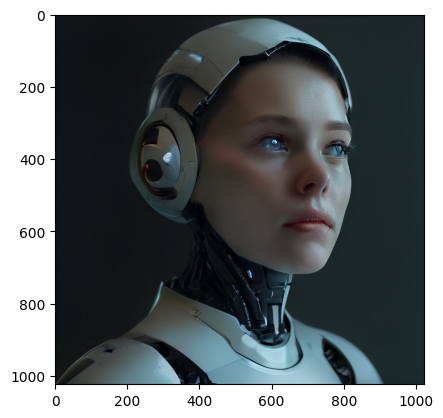

In [11]:
config_t2i = load_yaml('llava/eval/1024_eval.yaml')
config_t2i['config'].update(
    dict(guidance_scale=4))
seed = torch.manual_seed(42)
prompt = 'artificial intelligence,future, robot, humanoid, realistic, detailed, dramatic lighting, hyper realistic'
img = text_to_image(model,prompt,tokenizer=tokenizer,**config_t2i['config'],image_resolution=1024, n_tokens=4096,)
plt.imshow(img)

# Grounding

In [12]:
image = Image.open('assets/detection.jpg')
# edit_image = resize_and_center_crop(edit_image,1024)
device = 'cuda'
classes = ['old man', 'bed', 'window', 'guitar']
box = predict_grounding(model, image_processor, image, classes, mode='grand',tokenizer=tokenizer,steps=1)

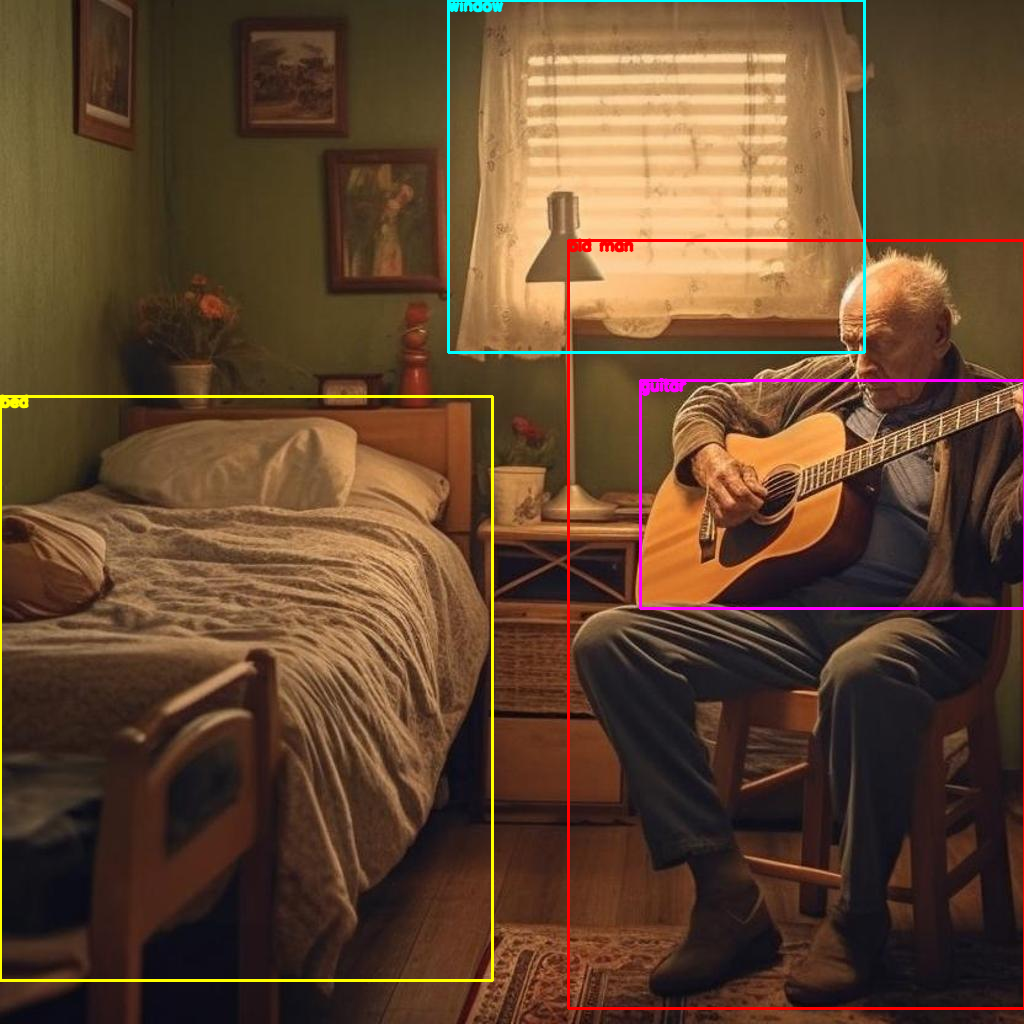

In [13]:
red = (255,0,0)
green = (255,255,0)
blue = (0,255,255)
purple = (255,0,255)
visualize_boxes(list(zip(classes,box)),resize_and_center_crop(image,1024),thickness=2,nolabel=False,colors=[red,green,blue,purple])

# Image Editing

In [14]:
edit_image = Image.open('assets/witch.jpg')
edit_image = resize_and_center_crop(edit_image,1024)
edit_prompt = "Turn the tree branche in the image into a witch’s magic wand."
config_edit = load_yaml('llava/eval/1024_eval_edit.yaml')
edit_result = text_to_image(model, edit_prompt, edit_image=edit_image,image_processor=image_processor,tokenizer=tokenizer,
                        **config_edit['config'],
                       image_resolution=1024, n_tokens=4096,
                )

<|startoftext|><|start_header_id|>system<|end_header_id|>

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.<|eot_id|><|start_header_id|>user<|end_header_id|>

<image> ***********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

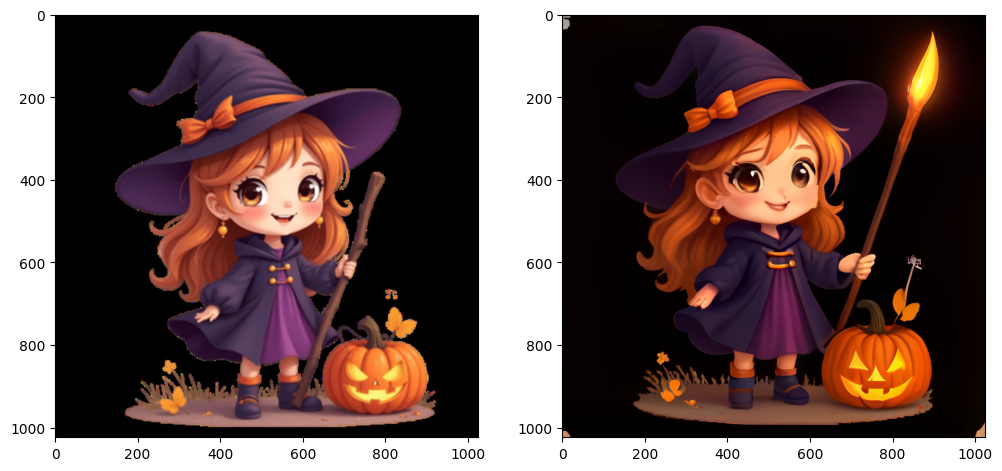

In [15]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(edit_image)
axes[1].imshow(edit_result)

# Image Understandng

In [16]:
device = model.device
input_image = Image.open('assets/detection.jpg')
input_image = resize_and_center_crop(input_image,1024)
image_tensor = process_images([input_image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.bfloat16, device=device) for _image in image_tensor]
conv_template = "llada" 
prompt = "Are there any person in the image? If so, what is he/she doing? Please also describe the look of the person"
question = f"<image>\n {prompt}."
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()
input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(model.device)
image_sizes = [edit_image.size]
res = model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=64,
    block_length=16,
    step_ratio=1, # 32 steps
    tokenizer=tokenizer,
    prefix_lm=True,
    verbose=True,
)
res = tokenizer.batch_decode(res[0],skip_special_tokens=True)[0]
print(res)

HH2
Yes, there is a person in the image. He is an elderly man with a gentle demeanor, sitting on a chair and playing an acoustic guitar. He has a distinguished appearance with his white hair and a serene expression.
